In [168]:
# created Aug 4 2023 by G Oldford to explore 
#  temporal crosscorrelation between model and obs
# will take LH SSS time series and model and apply moving average 
# then rescore
# input is output from analyze.py in pyap 

# to do: loop over all stations (lighthouses)
# store stats for each LH and plot ccoeff vs time horizon for Moving Avg on x (2023-08-04). plots should be panels or gridspec

In [2]:
import scipy.io
import os
import pickle
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import sys
from matplotlib import rcParams
from matplotlib.markers import MarkerStyle
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.colors as clr
from matplotlib.ticker import ScalarFormatter
import math
from math import log10, floor
from array import array
import numbers
from matplotlib.lines import Line2D
import warnings
from matplotlib.markers import MarkerStyle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import calendar
import warnings


# def fxn():
#     warnings.warn("runtime", RuntimeWarning)

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     fxn()

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# get lighthouse data

modelruns_info = {#'SalishSea1500-RUN203': {'path': 'D:/temp_nemo/RUN203_PLOTS_SCORES/',
#                                            'colour': 'r', 
#                                            'shortcode': 'RUN203', 'experiment': False}, 
                      'SalishSea1500-RUN216': {'path': 'D:/temp_nemo/RUN216/',
                                            'colour': 'b', 
                                           'shortcode': 'RUN216', 'experiment': False}#,
#                      'SalishSea500-201905': {'path': 'D:/temp_nemo/SS500/',
#                                            'colour': 'g', 
#                                            'shortcode': '201905', 'experiment': True}
                 }

modelrun = 'SalishSea1500-RUN216'
shortcode = modelruns_info[modelrun]['shortcode']
path1 = modelruns_info[modelrun]['path']

LH_pic_data = 'LH_class4_' + shortcode + '_hindcast.pickle'
LH_scores = pickle.load(open(os.path.join(path1,LH_pic_data), 'rb'))

In [3]:
LH_scores

{'SalishSea1500-RUN216': {'active_pass_LH.nc': {'lat': array(48.873, dtype=float32),
   'lon': array(-123.292, dtype=float32),
   'start': datetime.datetime(1980, 1, 1, 7, 0, 16),
   'end': datetime.datetime(2011, 12, 31, 10, 1, 36),
   'obs_file(s)': ['/project/6006412/goldford/OBS-WEST/LH/active_pass_LH.nc'],
   'raw_data': {'temperature': array([8.15581404, 8.0320538 , 8.08926041, ..., 6.29941324, 6.22834092,
           6.1989484 ]),
    'salinity': array([28.4393807 , 28.34369624, 28.46763234, ..., 25.63159206,
           25.55065414, 25.55231385]),
    'time': array([datetime.datetime(1980, 1, 1, 8, 0),
           datetime.datetime(1980, 1, 1, 9, 0),
           datetime.datetime(1980, 1, 1, 10, 0), ...,
           datetime.datetime(2018, 12, 31, 10, 0),
           datetime.datetime(2018, 12, 31, 11, 0),
           datetime.datetime(2018, 12, 31, 12, 0)], dtype=object),
    'station': 'active_pass',
    'filename': '/project/6006412/goldford/ANALYSIS/SalishSea1500-RUN216/EXTRACT/LH

In [18]:
print(len(LH_scores['SalishSea1500-RUN216']['active_pass_LH.nc']['filt_interp_data']['salinity']))
print(len(LH_scores['obs']['active_pass_LH.nc']['filt_interp_data']['salinity']))

11490
11490


In [30]:
obs_ts = (LH_scores['obs']['active_pass_LH.nc']['filt_interp_data']['timeseries']
LH_scores[modelrun]['active_pass_LH.nc']['filt_interp_data'].keys()

dict_keys(['scores', 'temperature', 'time', 'salinity'])

In [39]:
np.asarray(obs_ts[0])

array('time', dtype='<U4')

In [46]:
LH_scores['obs']['race_rocks_LH.nc']['filt_interp_data']['timeseries'][:]

['time', 'temperature', 'salinity']

In [20]:
def apply_2wk_filter(time_sorted, salt_sorted, use_nanmean=True):
    # Calculate the moving average with a two-week time step
    two_weeks_in_seconds = 2 * 7 * 24 * 60 * 60
    result_time = []
    result_salt = []

    start_time = time_sorted[0]
    end_time = time_sorted[-1]

    current_time = start_time
    while current_time <= end_time:
        time_mask = (time_sorted >= current_time) & (time_sorted < current_time + two_weeks_in_seconds)
        if use_nanmean:
            average_salt = np.nanmean(salt_sorted[time_mask])
        else:
            average_salt = np.mean(salt_sorted[time_mask])

        result_time.append(current_time)
        result_salt.append(average_salt)

        current_time += two_weeks_in_seconds

    # Convert the result_time back to datetime objects
    result_time = [datetime.fromtimestamp(ts) for ts in result_time]

    # Convert the result arrays to numpy arrays
    result_time = np.array(result_time)
    result_salt = np.array(result_salt)

    return result_time, result_salt

def seconds_in_one_month(year, month):
    _, num_days = calendar.monthrange(year, month)
    return num_days * 24 * 60 * 60


def apply_1mo_filter(time_sorted, salt_sorted, use_nanmean=True):
    # Find the start and end time
    start_time = datetime.fromtimestamp(time_sorted[0])
    end_time = datetime.fromtimestamp(time_sorted[-1])

    result_time = []
    result_salt = []

    current_time = start_time
    while current_time <= end_time:
        # Calculate the end of the current month
        end_of_month = current_time.replace(day=calendar.monthrange(current_time.year, current_time.month)[1])
        end_of_month = end_of_month.replace(hour=23, minute=59, second=59)

        # Create a time mask for the current month
        time_mask = (time_sorted >= current_time.timestamp()) & (time_sorted <= end_of_month.timestamp())

        # Calculate the average salt concentration for the current month
        if use_nanmean:
            average_salt = np.nanmean(salt_sorted[time_mask])
        else:
            average_salt = np.mean(salt_sorted[time_mask])

        result_time.append(current_time.timestamp())
        result_salt.append(average_salt)

        # Move to the next month
        current_time = end_of_month + timedelta(seconds=1)

    # Convert the result_time back to datetime objects
    result_time = [datetime.fromtimestamp(ts) for ts in result_time]

    # Convert the result arrays to numpy arrays
    result_time = np.array(result_time)
    result_salt = np.array(result_salt)
    return result_time, result_salt


# seasonal filter
def apply_3mo_filter(time_sorted, salt_sorted, use_nanmean=True):

    three_months_in_seconds = 3 * 30 * 24 * 60 * 60

    result_time = []
    result_salt = []

    start_time = datetime.fromtimestamp(time_sorted[0])
    end_time = datetime.fromtimestamp(time_sorted[-1])

    current_time = start_time
    while current_time <= end_time:
        # Calculate the end of the 4-month period
        end_of_period = current_time + timedelta(seconds=three_months_in_seconds)

        # Create a time mask for the current 4-month period
        time_mask = (time_sorted >= current_time.timestamp()) & (time_sorted < end_of_period.timestamp())

        # Calculate the average salt concentration for the current 4-month period
        if use_nanmean:
            average_salt = np.nanmean(salt_sorted[time_mask])
        else:
            average_salt = np.mean(salt_sorted[time_mask])

        result_time.append(current_time.timestamp())
        result_salt.append(average_salt)

        current_time += timedelta(seconds=three_months_in_seconds)

    # Convert the result_time back to datetime objects
    result_time = [datetime.fromtimestamp(ts) for ts in result_time]

    # Convert the result arrays to numpy arrays
    result_time = np.array(result_time)
    result_salt = np.array(result_salt)
    return result_time, result_salt

# seasonal filter
def apply_6mo_filter(time_sorted, salt_sorted, use_nanmean=True):

    three_months_in_seconds = 6 * 30 * 24 * 60 * 60

    result_time = []
    result_salt = []

    start_time = datetime.fromtimestamp(time_sorted[0])
    end_time = datetime.fromtimestamp(time_sorted[-1])

    current_time = start_time
    while current_time <= end_time:
        # Calculate the end of the 4-month period
        end_of_period = current_time + timedelta(seconds=three_months_in_seconds)

        # Create a time mask for the current 4-month period
        time_mask = (time_sorted >= current_time.timestamp()) & (time_sorted < end_of_period.timestamp())

        # Calculate the average salt concentration for the current 4-month period
        if use_nanmean:
            average_salt = np.nanmean(salt_sorted[time_mask])
        else:
            average_salt = np.mean(salt_sorted[time_mask])

        result_time.append(current_time.timestamp())
        result_salt.append(average_salt)

        current_time += timedelta(seconds=three_months_in_seconds)

    # Convert the result_time back to datetime objects
    result_time = [datetime.fromtimestamp(ts) for ts in result_time]

    # Convert the result arrays to numpy arrays
    result_time = np.array(result_time)
    result_salt = np.array(result_salt)
    return result_time, result_salt

# seasonal filter
def apply_1yr_filter(time_sorted, salt_sorted, use_nanmean=True):

    three_months_in_seconds = 12 * 30 * 24 * 60 * 60

    result_time = []
    result_salt = []

    start_time = datetime.fromtimestamp(time_sorted[0])
    end_time = datetime.fromtimestamp(time_sorted[-1])

    current_time = start_time
    while current_time <= end_time:
        # Calculate the end of the 4-month period
        end_of_period = current_time + timedelta(seconds=three_months_in_seconds)

        # Create a time mask for the current 4-month period
        time_mask = (time_sorted >= current_time.timestamp()) & (time_sorted < end_of_period.timestamp())

        # Calculate the average salt concentration for the current 4-month period
        if use_nanmean:
            average_salt = np.nanmean(salt_sorted[time_mask])
        else:
            average_salt = np.mean(salt_sorted[time_mask])

        result_time.append(current_time.timestamp())
        result_salt.append(average_salt)

        current_time += timedelta(seconds=three_months_in_seconds)

    # Convert the result_time back to datetime objects
    result_time = [datetime.fromtimestamp(ts) for ts in result_time]

    # Convert the result arrays to numpy arrays
    result_time = np.array(result_time)
    result_salt = np.array(result_salt)
    return result_time, result_salt

# alt pearsons R
def pearson2 (obs, mod):
    mod = np.asarray(mod)
    obs = np.asarray(obs)
    R = (1 / (np.nanstd(mod) * np.nanstd(obs)) ) * (np.sum( (mod - np.nanmean(mod)) * (obs - np.nanmean(obs)) )  / len(obs))
    return R

def Willmott1981(obs, mod, axis=0):
    
    mod = np.asarray(mod) # add by GO
    obs = np.asarray(obs)
    
    num = np.nansum((mod - obs) ** 2, axis=axis)
    obs_mean = np.nanmean(obs, axis=axis)
    dM = np.abs(mod - obs_mean)
    dO = np.abs(obs - obs_mean)
    den = np.nansum((dM + dO) ** 2, axis=axis)
    if den == 0:
        return np.nan
    else:
        return np.max([0, 1 - num / den])

# generic mvg avg filter using user-defined months and / or days
def apply_mvgavg_filter(time_sorted, salt_sorted, mos=1, dys=30, use_nanmean=True):

    three_months_in_seconds = mos * dys * 24 * 60 * 60

    result_time = []
    result_salt = []

    start_time = datetime.fromtimestamp(time_sorted[0])
    end_time = datetime.fromtimestamp(time_sorted[-1])

    current_time = start_time
    while current_time <= end_time:
        # Calculate the end of the 4-month period
        end_of_period = current_time + timedelta(seconds=three_months_in_seconds)

        # Create a time mask for the current 4-month period
        time_mask = (time_sorted >= current_time.timestamp()) & (time_sorted < end_of_period.timestamp())

        # Calculate the average salt concentration for the current 4-month period
        if use_nanmean:
            average_salt = np.nanmean(salt_sorted[time_mask])
        else:
            average_salt = np.mean(salt_sorted[time_mask])

        result_time.append(current_time.timestamp())
        result_salt.append(average_salt)

        current_time += timedelta(seconds=three_months_in_seconds)

    # Convert the result_time back to datetime objects
    result_time = [datetime.fromtimestamp(ts) for ts in result_time]

    # Convert the result arrays to numpy arrays
    result_time = np.array(result_time)
    result_salt = np.array(result_salt)
    return result_time, result_salt

C:\Users\Greig\AppData\Local\Temp\ipykernel_10656\2992802057.py:232: RuntimeWarning: Mean of empty slice
  average_salt = np.nanmean(salt_sorted[time_mask])


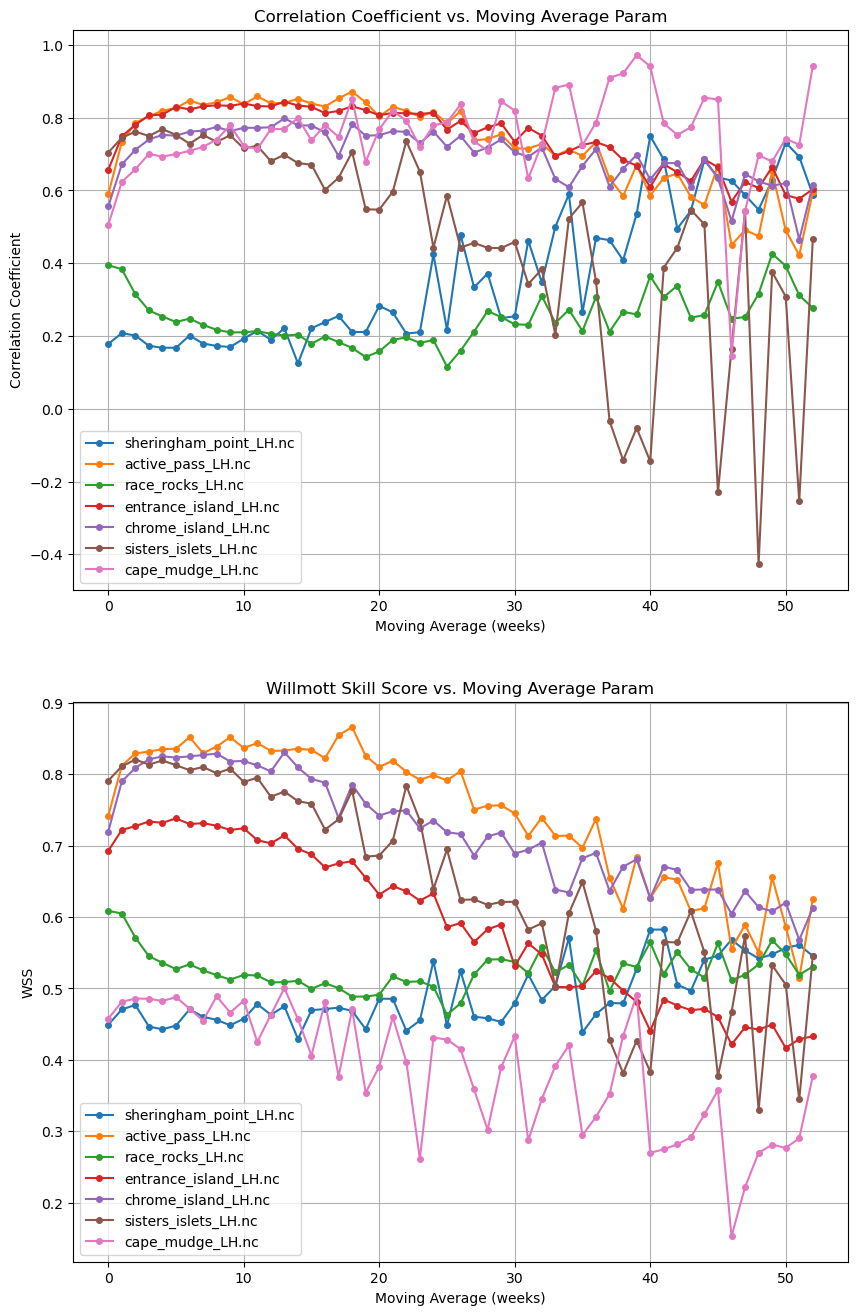

In [65]:

# Create lists to store correlation coefficients and moving average parameters
# ccoeffs_dict = {lh: [] for lh in LH_scores['obs'].keys()}
# wss_dict = {lh: [] for lh in LH_scores['obs'].keys()}
# mvgavg_vals_obs_dict = {lh: [] for lh in LH_scores['obs'].keys()}
# mvgavg_vals_mod_dict = {lh: [] for lh in LH_scores['obs'].keys()}


data_dict = {lh: {'ccoeffs': [], 'wss': [], 's_vals_or_avgs_obs': {}, 's_vals_or_avgs_mod': {}} for lh in LH_scores['obs'].keys()}

moving_avg_params = []
use_nanmean = True

# Calculate the correlation coefficient for the original data
for lh in LH_scores['obs'].keys():
    
    time_obs = np.asarray(LH_scores['obs'][lh]['filt_interp_data']['time'])
    salt_obs = np.asarray(LH_scores['obs'][lh]['filt_interp_data']['salinity'].astype('f'))
    time_mod = np.asarray(LH_scores[modelrun][lh]['filt_interp_data']['time'])
    salt_mod = np.asarray(LH_scores[modelrun][lh]['filt_interp_data']['salinity'].astype('f'))
    
    # there is a weird outlier in sisters islet data - remove
    salt_obs2 = salt_obs[salt_obs < 44]
    salt_mod = salt_mod[salt_obs < 44]
    time_obs = time_obs[salt_obs < 44]
    time_mod = time_mod[salt_obs < 44]
    salt_obs = salt_obs2
    
    # format to datetime
    time_obs_numeric = np.array([dt.timestamp() for dt in time_obs])
    time_mod_numeric = np.array([dt.timestamp() for dt in time_mod])

    # sort
    sort_indices = np.argsort(time_obs_numeric)
    time_sort_o = time_obs_numeric[sort_indices]
    salt_sort_o = salt_obs[sort_indices]

    sort_indices = np.argsort(time_mod_numeric)
    time_sort_m = time_mod_numeric[sort_indices]
    salt_sort_m = salt_mod[sort_indices]
    
    
    # Calculate correlation coefficient between original and moving average time series
    if use_nanmean:
        salt_sort_m_nonan = salt_sort_m[~np.isnan(salt_sort_m) & ~np.isnan(salt_sort_o)]
        salt_sort_o_nonan = salt_sort_o[~np.isnan(salt_sort_o) & ~np.isnan(salt_sort_m)]
        ccoeff = np.corrcoef(salt_sort_o_nonan, salt_sort_m_nonan)[0, 1]
        wss = Willmott1981(salt_sort_o_nonan, salt_sort_m_nonan)
    else:
        ccoeff = np.corrcoef(salt_sort_o, salt_sort_m)[0, 1]
        wss = Willmott1981(salt_sort_o, salt_sort_m)
    
    # Append correlation coefficient to the dictionary for the current lighthouse
    data_dict[lh]['ccoeffs'].append(ccoeff)
    data_dict[lh]['wss'].append(wss)
    data_dict[lh]['s_vals_or_avgs_obs'][1] = salt_sort_o # 1 for units of time in days
    data_dict[lh]['s_vals_or_avgs_mod'][1] = salt_sort_m
    
    moving_avg_params.append(1)


# Loop over different moving average parameters
for mvg_avg_days in range(7, 365 + 1, 7):  # From 1 week to 1 year at 1 week increments
#     print("Moving Average:", mvg_avg_days, "days")

    # Loop over lighthouses
    for lh in LH_scores['obs'].keys():
        
        time_obs = np.asarray(LH_scores['obs'][lh]['filt_interp_data']['time'])
        salt_obs = np.asarray(LH_scores['obs'][lh]['filt_interp_data']['salinity'].astype('f'))
        time_mod = np.asarray(LH_scores[modelrun][lh]['filt_interp_data']['time'])
        salt_mod = np.asarray(LH_scores[modelrun][lh]['filt_interp_data']['salinity'].astype('f'))
        
        # there is a weird outlier in sisters islet data - remove

        salt_obs2 = salt_obs[salt_obs < 44]
        salt_mod = salt_mod[salt_obs < 44]
        time_obs = time_obs[salt_obs < 44]
        time_mod = time_mod[salt_obs < 44]
        salt_obs = salt_obs2
    

        # format to datetime
        time_obs_numeric = np.array([dt.timestamp() for dt in time_obs])
        time_mod_numeric = np.array([dt.timestamp() for dt in time_mod])

        # sort
        sort_indices = np.argsort(time_obs_numeric)
        time_sort_o = time_obs_numeric[sort_indices]
        salt_sort_o = salt_obs[sort_indices]

        sort_indices = np.argsort(time_mod_numeric)
        time_sort_m = time_mod_numeric[sort_indices]
        salt_sort_m = salt_mod[sort_indices]
        

        # Calculate moving average time series for observed and modeled data
        time_obs_mvgavg, salt_obs_mvgavg = apply_mvgavg_filter(time_sort_o, salt_sort_o, 1, mvg_avg_days, use_nanmean)
        time_mod_mvgavg, salt_mod_mvgavg = apply_mvgavg_filter(time_sort_m, salt_sort_m, 1, mvg_avg_days, use_nanmean)        
        
        # Calculate correlation coefficient between original and moving average time series
        if use_nanmean:
            salt_mod_mvgavg_nonan = salt_mod_mvgavg[~np.isnan(salt_mod_mvgavg) & ~np.isnan(salt_obs_mvgavg)]
            salt_obs_mvgavg_nonan = salt_obs_mvgavg[~np.isnan(salt_obs_mvgavg) & ~np.isnan(salt_mod_mvgavg)]
            ccoeff = np.corrcoef(salt_obs_mvgavg_nonan, salt_mod_mvgavg_nonan)[0, 1]
            wss = Willmott1981(salt_obs_mvgavg_nonan, salt_mod_mvgavg_nonan)
        else:
            ccoeff = np.corrcoef(salt_obs_mvgavg, salt_mod_mvgavg)[0, 1]
            wss = Willmott1981(salt_obs_mvgavg, salt_mod_mvgavg)

        # Append correlation coefficient and moving average parameter to lists
        data_dict[lh]['ccoeffs'].append(ccoeff)
        data_dict[lh]['wss'].append(wss)
        data_dict[lh]['s_vals_or_avgs_obs'][mvg_avg_days] = salt_obs_mvgavg
        data_dict[lh]['s_vals_or_avgs_mod'][mvg_avg_days] = salt_mod_mvgavg

        moving_avg_params.append(mvg_avg_days)

# Convert moving_avg_params to weeks for x-axis labeling
# moving_avg_params_weeks = [days / 7 for days in moving_avg_params]
moving_avg_params_weeks = [days / 7 for days in range(0, 365 + 1, 7)]

# Plot the data for each lighthouse using Matplotlib
plt.figure(figsize=(10, 16))
plt.subplot(211)

for lh in LH_scores['obs'].keys():
    plt.plot(moving_avg_params_weeks, data_dict[lh]['ccoeffs'], marker='o', label=lh, markersize=4)

plt.xlabel("Moving Average (weeks)")
plt.ylabel("Correlation Coefficient")
plt.title("Correlation Coefficient vs. Moving Average Param")
plt.grid(True)
plt.legend()

plt.subplot(212)
for lh in LH_scores['obs'].keys():
    plt.plot(moving_avg_params_weeks, data_dict[lh]['wss'], marker='o', label=lh, markersize=4)
plt.xlabel("Moving Average (weeks)")
plt.ylabel("WSS")
plt.title("Willmott Skill Score vs. Moving Average Param")
plt.grid(True)
plt.legend()

plt.show()

In [1]:

plt.figure(figsize=(12, 40))

num_lh = len(LH_scores['obs'].keys())
plt_num = 0 
for lh in LH_scores['obs'].keys():
    moving_avg = 28 # days
    plt_num += 1
    plt.subplot(num_lh,1,plt_num)
    plt.plot(data_dict[lh]['s_vals_or_avgs_obs'][moving_avg], label='obs.', color='r', linewidth=0.3)
    plt.plot(data_dict[lh]['s_vals_or_avgs_mod'][moving_avg], label='mod.', color='b', linewidth=0.3)

    plt.xlabel('Time')
    plt.ylabel('Salinity (PSU)')
    plt.title(lh + ' SSS mod v. obs, mvg avg of ' + str(moving_avg) + ' days')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

sheringham_point_LH.nc
active_pass_LH.nc
race_rocks_LH.nc


C:\Users\Greig\AppData\Local\Temp\ipykernel_8336\1625477097.py:14: RuntimeWarning: Mean of empty slice
  average_salt = np.nanmean(salt_sorted[time_mask])
C:\Users\Greig\AppData\Local\Temp\ipykernel_8336\1625477097.py:56: RuntimeWarning: Mean of empty slice
  average_salt = np.nanmean(salt_sorted[time_mask])
C:\Users\Greig\AppData\Local\Temp\ipykernel_8336\1625477097.py:96: RuntimeWarning: Mean of empty slice
  average_salt = np.nanmean(salt_sorted[time_mask])


6mo
[31.130713 30.970291 31.000841 30.629097 30.711313 30.563894 31.006428
 30.660265 30.827995 30.520239 31.087965 30.971832 31.186653 30.667437
 31.191965 30.901611 31.276747 30.490767 31.298592 30.76479  31.372679
 30.608152 31.181044 30.537668 31.256063 30.661312 31.231007 30.54268
 31.366673 30.611303 31.38664  30.636206 31.185192 30.388422 31.241001
 30.205223 30.931274 30.582525 30.999876 30.218744 31.043146 30.720005
 31.152094 31.055696 31.204096 30.72534  31.266222 30.814888 31.219198
 30.910822 31.128918 30.734526 31.141533 30.775879 31.388617 30.852976
 31.091242 30.987288 31.187239 31.259624 31.291426 31.012428 31.015684
 30.68646  30.651203 30.949942 30.583847 31.053436 30.897055 31.31002
 30.874855 30.804575 30.917377 30.923534 30.778273 30.923944 30.62451
 31.12056  30.941603 31.682024]
[31.553331 31.908333 31.507734 31.990957 31.188826 31.355556 30.744198
 31.064245 30.767403 31.23     31.50782  31.755003 31.379557 31.502222
 31.213406 31.626665 31.560558 31.756737 31.

C:\Users\Greig\AppData\Local\Temp\ipykernel_8336\1625477097.py:134: RuntimeWarning: Mean of empty slice
  average_salt = np.nanmean(salt_sorted[time_mask])
C:\Users\Greig\AppData\Local\Temp\ipykernel_8336\1625477097.py:172: RuntimeWarning: Mean of empty slice
  average_salt = np.nanmean(salt_sorted[time_mask])


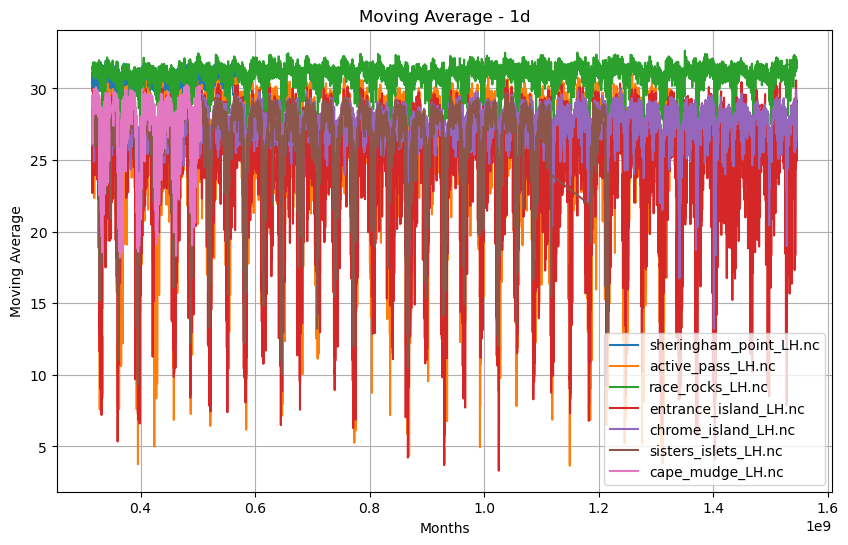

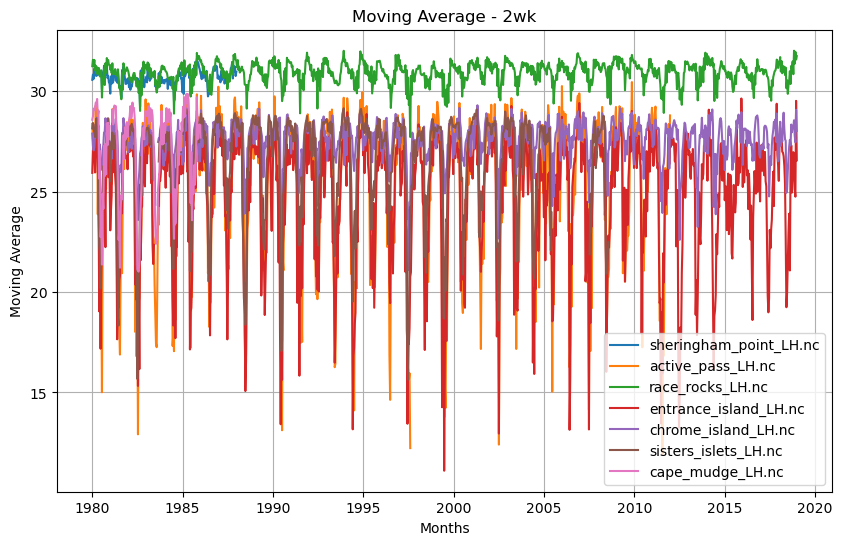

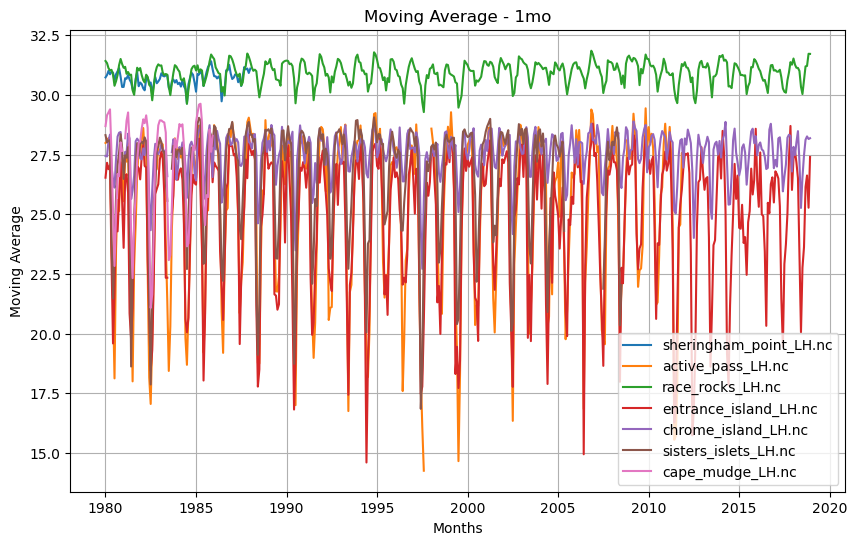

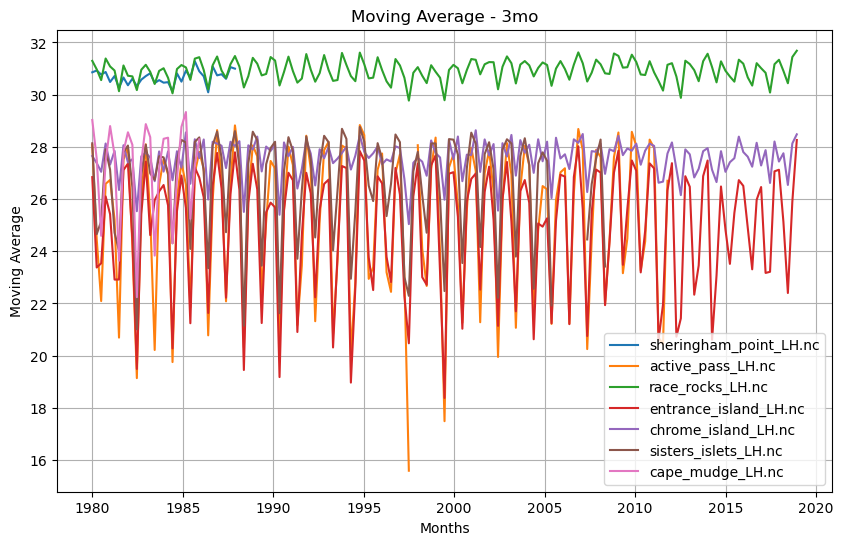

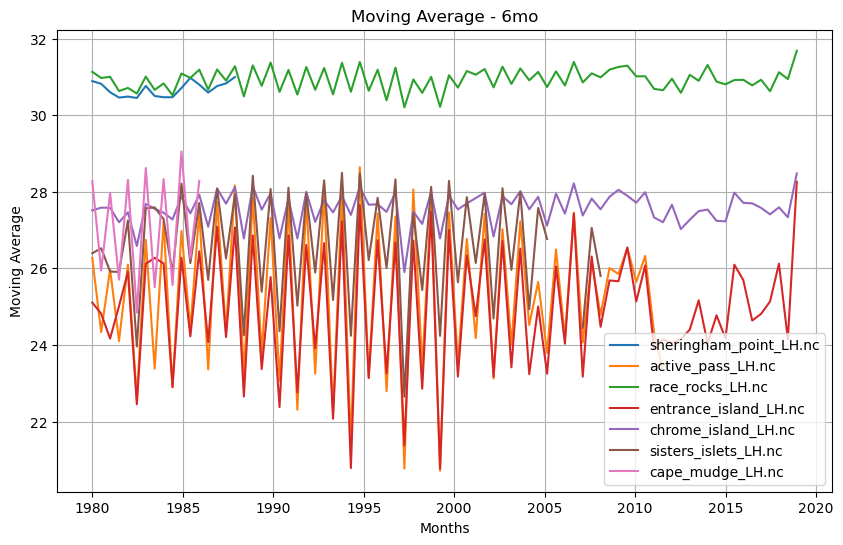

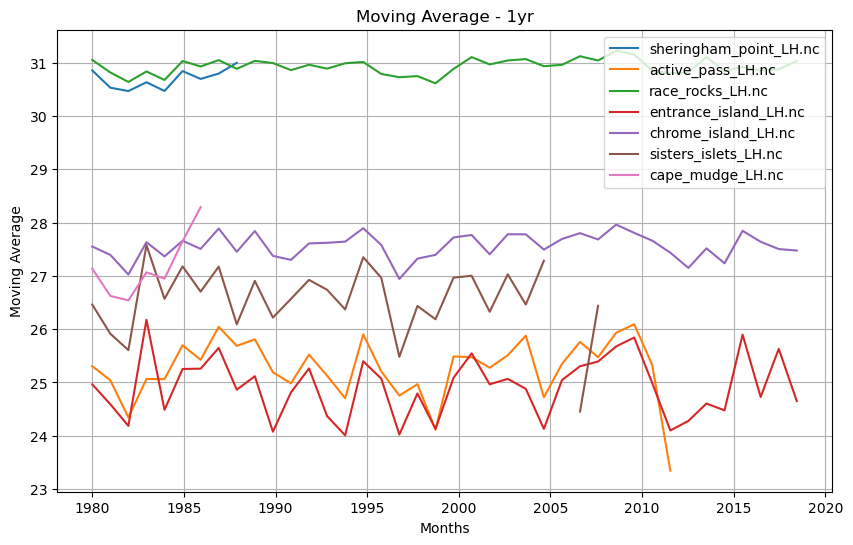

In [57]:
# Old code

# lh = 'chrome_island_LH.nc'
lhs = []

# Create dictionaries to store moving average data
moving_avg_data = {
    '1d': [],
    '2wk': [],
    '1mo': [],
    '3mo': [],
    '6mo': [],
    '1yr': []
}

ccoeffs = {
    'lh': [],
    '1d': [],
    '2wk': [],
    '2wk': [],
    '1mo': [],
    '3mo': [],
    '6mo': [],
    '1yr': []
}

use_nanmean = True

for lh in LH_scores['obs'].keys():
    
    print(lh)
    lhs.append(lh)

    # get data from original dictionary format
    time_obs = np.asarray(LH_scores['obs'][lh]['filt_interp_data']['time'])
    salt_obs = np.asarray(LH_scores['obs'][lh]['filt_interp_data']['salinity'].astype('f'))
    time_mod = np.asarray(LH_scores[modelrun][lh]['filt_interp_data']['time'])
    salt_mod = np.asarray(LH_scores[modelrun][lh]['filt_interp_data']['salinity'].astype('f'))

    # format to datetime
    time_obs_numeric = np.array([dt.timestamp() for dt in time_obs])
    time_mod_numeric = np.array([dt.timestamp() for dt in time_mod])

    # sort
    sort_indices = np.argsort(time_obs_numeric)
    time_sort_o = time_obs_numeric[sort_indices]
    salt_sort_o = salt_obs[sort_indices]

    sort_indices = np.argsort(time_mod_numeric)
    time_sort_m = time_mod_numeric[sort_indices]
    salt_sort_m = salt_mod[sort_indices]

    # get two week moving avg
    time_2wk_o, s_2wk_o = apply_2wk_filter(time_sort_o, salt_sort_o, use_nanmean)
    time_2wk_m, s_2wk_m = apply_2wk_filter(time_sort_m, salt_sort_m, use_nanmean)

    # get monthly moving avg
    time_1mo_o, s_1mo_o = apply_1mo_filter(time_sort_o, salt_sort_o, use_nanmean)
    time_1mo_m, s_1mo_m = apply_1mo_filter(time_sort_m, salt_sort_m, use_nanmean)

    # get seasonal moving avg
    time_3mo_o, s_3mo_o = apply_3mo_filter(time_sort_o, salt_sort_o, use_nanmean)
    time_3mo_m, s_3mo_m = apply_3mo_filter(time_sort_m, salt_sort_m, use_nanmean)

    # get 6 mo moving avg
    time_6mo_o, s_6mo_o = apply_6mo_filter(time_sort_o, salt_sort_o, use_nanmean)
    time_6mo_m, s_6mo_m = apply_6mo_filter(time_sort_m, salt_sort_m, use_nanmean)
    
    # get 1 yr moving avg
    time_1yr_o, s_1yr_o = apply_1yr_filter(time_sort_o, salt_sort_o, use_nanmean)
    time_1yr_m, s_1yr_m = apply_1yr_filter(time_sort_m, salt_sort_m, use_nanmean)
    
    # store time series
#     moving_avg_data['lh'].append((lh, lh))
    moving_avg_data['1d'].append((time_sort_m, salt_sort_m))
    moving_avg_data['2wk'].append((time_2wk_m, s_2wk_m))
    moving_avg_data['1mo'].append((time_1mo_m, s_1mo_m))
    moving_avg_data['3mo'].append((time_3mo_m, s_3mo_m))
    moving_avg_data['6mo'].append((time_6mo_m, s_6mo_m))
    moving_avg_data['1yr'].append((time_1yr_m, s_1yr_m))
    
    # calculate and store statistics
    # No moving average
    salt_sort_m_nonan = salt_sort_m[~np.isnan(salt_sort_m) & ~np.isnan(salt_sort_o)]
    salt_sort_o_nonan = salt_sort_o[~np.isnan(salt_sort_o) & ~np.isnan(salt_sort_m)]
    ccoeff = np.corrcoef(salt_sort_m_nonan,salt_sort_o_nonan)
    
    # 2 wk moving avg
    s_2wk_m_nonan = s_2wk_m[~np.isnan(s_2wk_m) & ~np.isnan(s_2wk_o)]
    s_2wk_o_nonan = s_2wk_o[~np.isnan(s_2wk_o) & ~np.isnan(s_2wk_m)]
    ccoeff_2wk = np.corrcoef(s_2wk_m_nonan,s_2wk_o_nonan)    
    
    # monthly moving avg
    s_1mo_m_nonan = s_1mo_m[~np.isnan(s_1mo_m) & ~np.isnan(s_1mo_o)]
    s_1mo_o_nonan = s_1mo_o[~np.isnan(s_1mo_o) & ~np.isnan(s_1mo_m)]
    ccoeff_1mo = np.corrcoef(s_1mo_m_nonan,s_1mo_o_nonan)  
    
    # 3 mo (seasonal) moving avg
    s_3mo_m_nonan = s_3mo_m[~np.isnan(s_3mo_m) & ~np.isnan(s_3mo_o)]
    s_3mo_o_nonan = s_3mo_o[~np.isnan(s_3mo_o) & ~np.isnan(s_3mo_m)]
    ccoeff_3mo = np.corrcoef(s_3mo_m_nonan,s_3mo_o_nonan)  

    # 6 mo (seasonal) moving avg
    s_6mo_m_nonan = s_6mo_m[~np.isnan(s_6mo_m) & ~np.isnan(s_6mo_o)]
    s_6mo_o_nonan = s_6mo_o[~np.isnan(s_6mo_o) & ~np.isnan(s_6mo_m)]
    ccoeff_6mo = np.corrcoef(s_6mo_m_nonan,s_6mo_o_nonan)    

    # 1 yr (seasonal) moving avg
    s_1yr_m_nonan = s_1yr_m[~np.isnan(s_1yr_m) & ~np.isnan(s_1yr_o)]
    s_1yr_o_nonan = s_1yr_o[~np.isnan(s_1yr_o) & ~np.isnan(s_1yr_m)]
    ccoeff_1yr = np.corrcoef(s_1yr_m_nonan,s_1yr_o_nonan) 

    if lh == "race_rocks_LH.nc":
        print("6mo")
        print(s_6mo_m_nonan)
        print(s_6mo_o_nonan)
        print(ccoeff_6mo)
        print("1yr")
        print(s_1yr_m_nonan)
        print(s_1yr_o_nonan)
        print(ccoeff_1yr)
    
    # ccoeff = sp.stats.pearsonr(s_1mo_m_nonan, s_1mo_o_nonan) 

    # Calculate standard deviation for both datasets
#     std_salt_obs = np.nanstd(salt_sort_o)
#     std_salt_mod = np.nanstd(salt_sort_m)

    # store stats
    ccoeffs['lh'].append((lh))
    ccoeffs['1d'].append((1, ccoeff[0,1]))
    ccoeffs['2wk'].append((14,ccoeff_2wk[0,1]))
    ccoeffs['1mo'].append((30,ccoeff_1mo[0,1]))
    ccoeffs['3mo'].append((90,ccoeff_3mo[0,1]))
    ccoeffs['6mo'].append((180, ccoeff_6mo[0,1]))
    ccoeffs['1yr'].append((365, ccoeff_1yr[0,1]))
    

# Plotting using Matplotlib
for avg_type, avg_data_list in moving_avg_data.items():
    plt.figure(figsize=(10, 6))
    plt.title(f'Moving Average - {avg_type}')
    plt.xlabel('Months')
    plt.ylabel('Moving Average')
    
    for lh_index, (lh_name, (time_data, avg_data)) in enumerate(zip(lhs, avg_data_list)):
        plt.plot(time_data, avg_data, label=f'{lh_name}')
        
    plt.legend()
    plt.grid()
    plt.show()


In [36]:
ccoeffs['1d'][0]

(1, 0.17803240400391854)

In [29]:
plt.figure(figsize=(10, 6))
plt.title(f'Moving Average - {avg_type}')
plt.xlabel('Days')
plt.ylabel('Moving Average')

# for avg_type, avg_data_list in moving_avg_data.items():
ti = ['1d','2wk','1mo','3mo','6mo','1yr']
i = 0
for lh in ccoeffs['lh']:
    
    xs = []
    ys = []
    for t in ti:
        print(ccoeffs[t][i])
        xs.append(ccoeffs[t][i][0])
        ys.append(ccoeffs[t][i][1])
        
    plt.plot(xs,ys)
#         plt.plot(time_data, avg_data, label=f'{lh_name}')
    
#     for lh_index, (lh_name, (time_data, avg_data)) in enumerate(zip(lhs, avg_data_list)):
#         plt.plot(time_data, avg_data, label=f'{lh_name}')
    i += 1 
    
    
#     plt.legend()
plt.grid()
plt.show()
    

NameError: name 'avg_type' is not defined

<Figure size 1000x600 with 0 Axes>

In [43]:
print(len(ccoeffs))

7


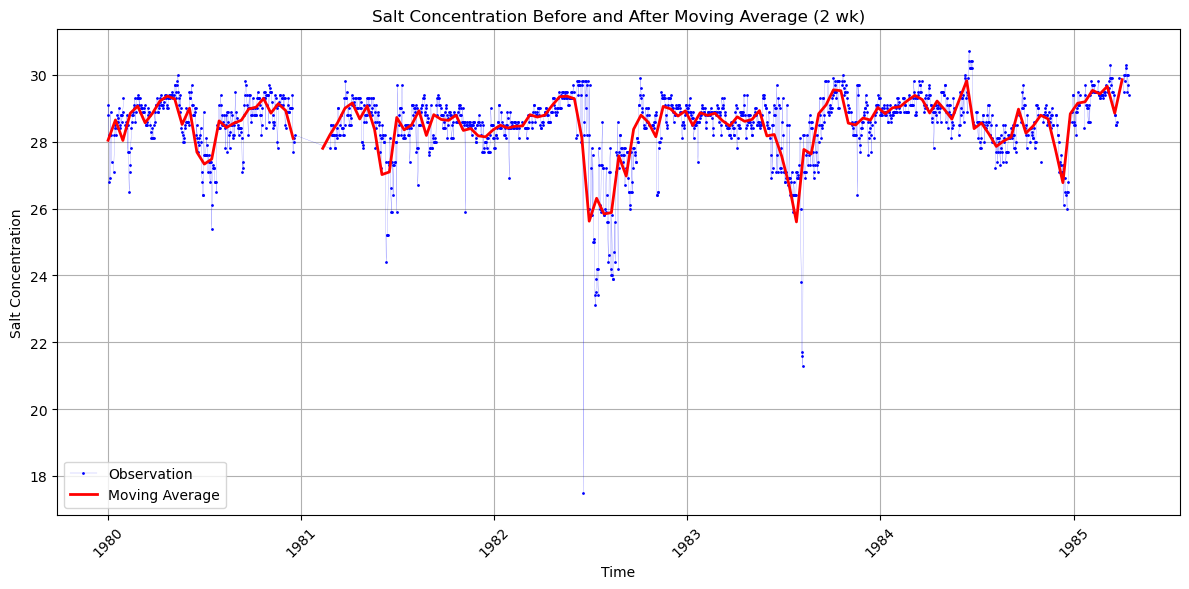

In [13]:
plt.figure(figsize=(12, 6))

# Plot the original data
plt.plot(time_obs, salt_obs, label='Observation', color='b', marker='o', linestyle='-', markersize=1, linewidth=0.1, zorder=10)
# plt.plot(time_mod, salt_mod, label='Model', color='g', marker='o', linestyle='-', markersize=4)

# Plot the data after applying the moving average
plt.plot(time_2wk_o, s_2wk_o, label='Moving Average', color='r', linewidth=2, zorder=10)

plt.xlabel('Time')
plt.ylabel('Salt Concentration')
plt.title('Salt Concentration Before and After Moving Average (2 wk)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


NameError: name 'time_2wk_m' is not defined

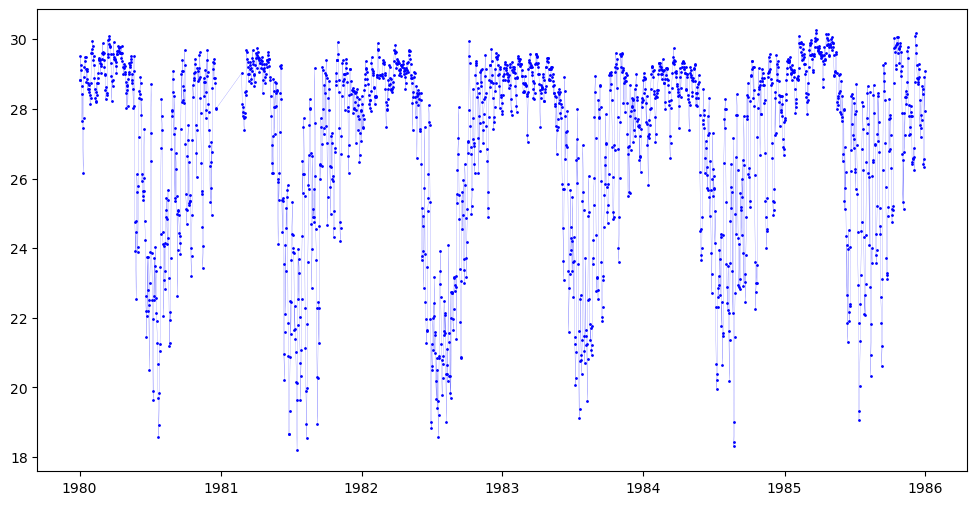

In [30]:
plt.figure(figsize=(12, 6))

# Plot the original data
plt.plot(time_mod, salt_mod, label='Model', color='b', marker='o', linestyle='-', markersize=1, linewidth=0.1, zorder=10)
# plt.plot(time_mod, salt_mod, label='Model', color='g', marker='o', linestyle='-', markersize=4)

# Plot the data after applying the moving average
plt.plot(time_2wk_m, s_2wk_m, label='Moving Average', color='r', linewidth=2, zorder=10)

plt.xlabel('Time')
plt.ylabel('Salt Concentration')
plt.title('Salt Concentration Before and After Moving Average (model)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

NameError: name 'time_4mo_o' is not defined

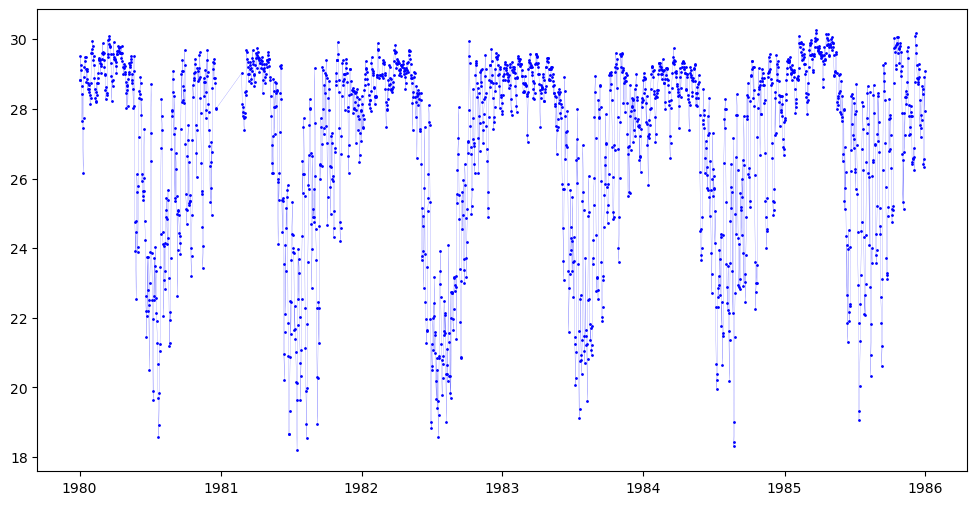

In [10]:
plt.figure(figsize=(12, 6))

# Plot the original data
plt.plot(time_mod, salt_mod, label='Observations', color='b', marker='o', linestyle='-', markersize=1, linewidth=0.1, zorder=10)
# plt.plot(time_mod, salt_mod, label='Model', color='g', marker='o', linestyle='-', markersize=4)

# Plot the data after applying the moving average
plt.plot(time_4mo_o, s_4mo_o, label='Seasonal (4 mo.) Moving Average', color='r', linewidth=3, zorder=10)

plt.xlabel('Time')
plt.ylabel('Salt Concentration')
plt.title('Obs. Salt Concentration Before and After Moving Average (4 mo.)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))

# Plot the original data
plt.plot(time_mod, salt_mod, label='Model', color='b', marker='o', linestyle='-', markersize=1, linewidth=0.1, zorder=10)
# plt.plot(time_mod, salt_mod, label='Model', color='g', marker='o', linestyle='-', markersize=4)

# Plot the data after applying the moving average
plt.plot(time_4mo_m, s_4mo_m, label='Seasonal (4 mo.) Moving Average', color='r', linewidth=3, zorder=10)

plt.xlabel('Time')
plt.ylabel('Salt Concentration')
plt.title('Model Salt Concentration Before and After Moving Average (4 mo.)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

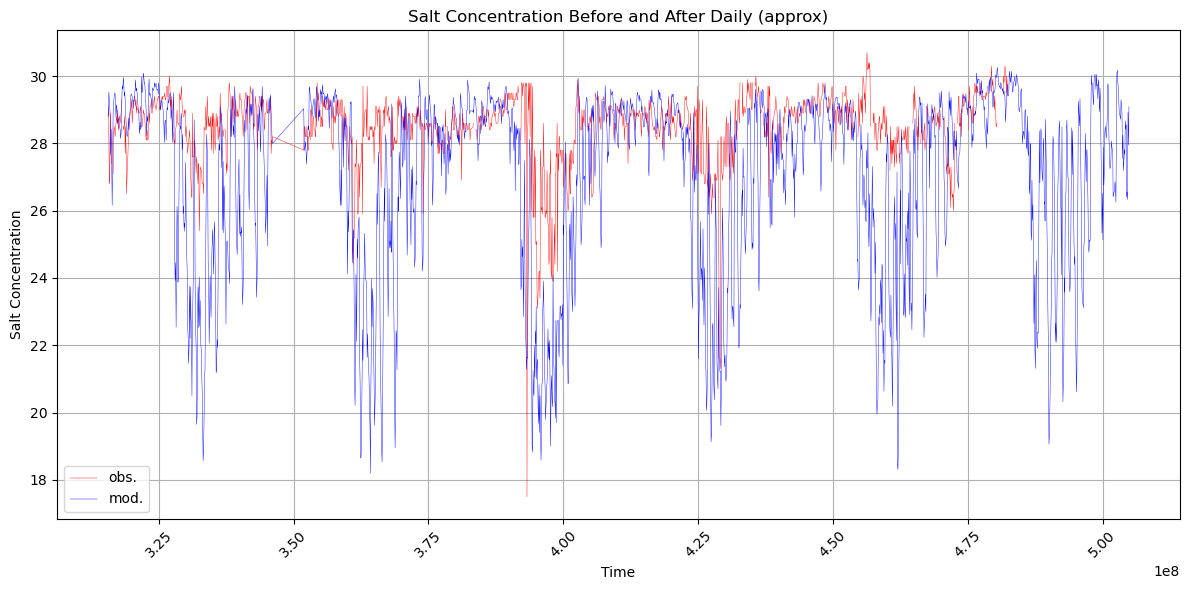

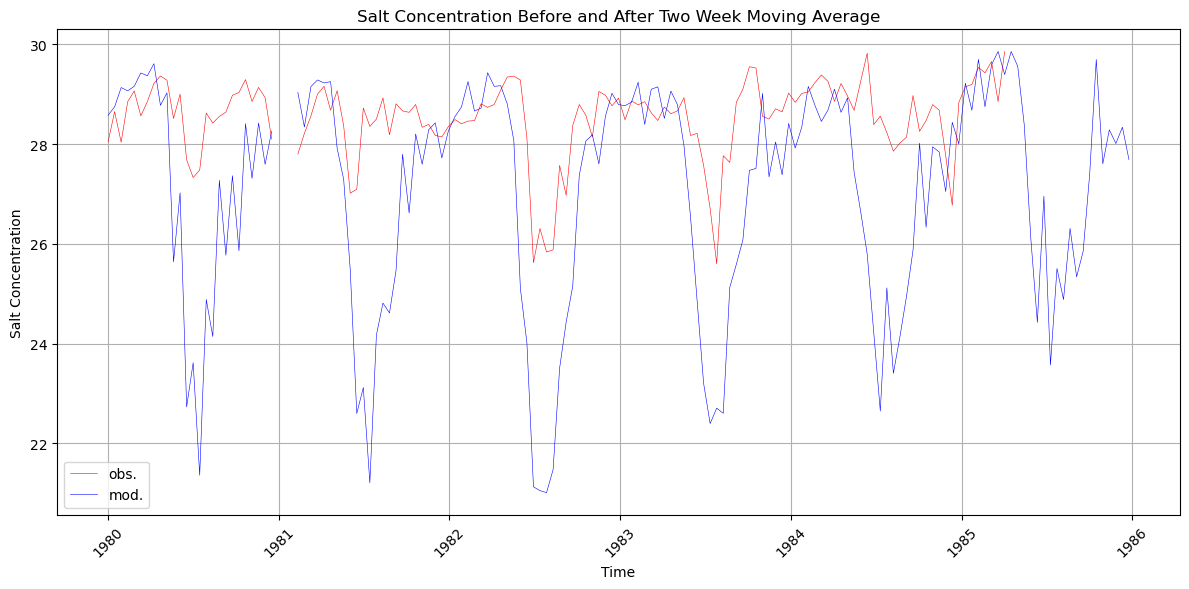

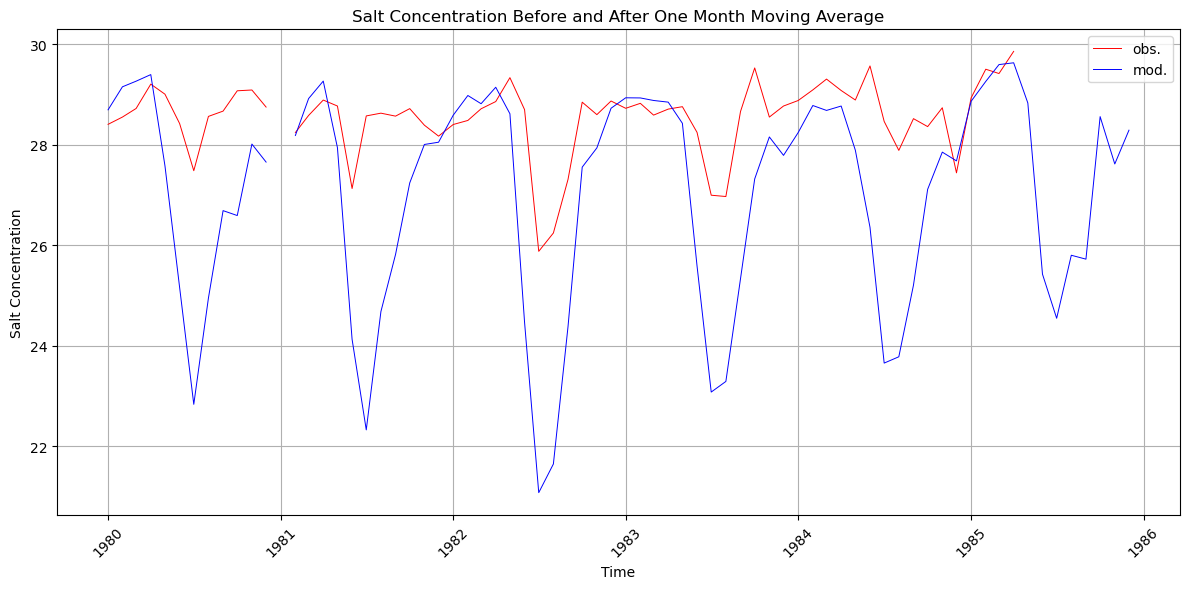

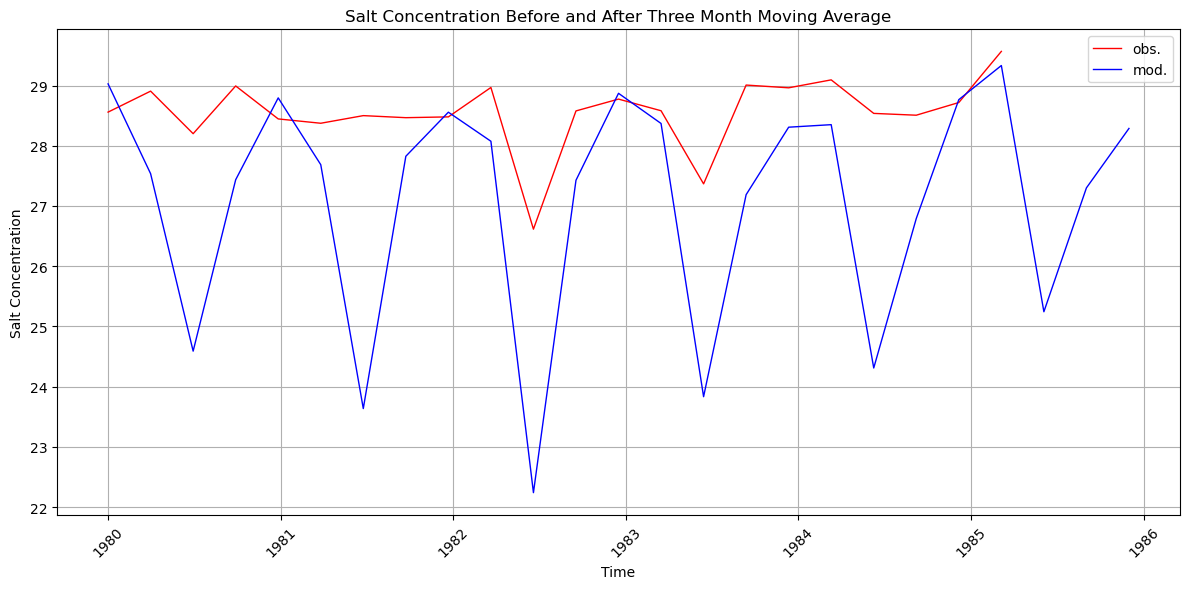

In [11]:
plt.figure(figsize=(12, 6))

# Plot the original dThree
# plt.plot(time_mod, salt_mod, label='Observation', color='b', marker='o', linestyle='-', markersize=1, linewidth=0.1, zorder=10)
# plt.plot(time_mod, salt_mod, label='Model', color='g', marker='o', linestyle='-', markersize=4)
# plt.plot(time_mod, salt_mod, label='Observations', color='b', marker='o', linestyle='-', markersize=1, linewidth=0.1, zorder=10)

plt.figure(figsize=(12, 6))
plt.plot(time_sort_o, salt_sort_o, label='obs.', color='r', linewidth=0.3)
plt.plot(time_sort_m, salt_sort_m, label='mod.', color='b', linewidth=0.3)


plt.xlabel('Time')
plt.ylabel('Salt Concentration')
plt.title('Salt Concentration Before and After Daily (approx)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



# Plot the data after applying the moving average
plt.figure(figsize=(12, 6))
plt.plot(time_2wk_o, s_2wk_o, label='obs.', color='r', linewidth=0.4)
plt.plot(time_2wk_m, s_2wk_m, label='mod.', color='b', linewidth=0.4)


plt.xlabel('Time')
plt.ylabel('Salt Concentration')
plt.title('Salt Concentration Before and After Two Week Moving Average')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



# Plot the data after applying the moving average
plt.figure(figsize=(12, 6))
plt.plot(time_1mo_o, s_1mo_o, label='obs.', color='r', linewidth=0.7)
plt.plot(time_1mo_m, s_1mo_m, label='mod.', color='b', linewidth=0.7)


plt.xlabel('Time')
plt.ylabel('Salt Concentration')
plt.title('Salt Concentration Before and After One Month Moving Average')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



# Plot the data after applying the moving average
plt.figure(figsize=(12, 6))
plt.plot(time_3mo_o, s_3mo_o, label='obs.', color='r', linewidth=1)
plt.plot(time_3mo_m, s_3mo_m, label='mod.', color='b', linewidth=1)


plt.xlabel('Time')
plt.ylabel('Salt Concentration')
plt.title('Salt Concentration Before and After Three Month Moving Average')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [12]:
# No moving average
salt_sort_m_nonan = salt_sort_m[~np.isnan(salt_sort_m) & ~np.isnan(salt_sort_o)]
salt_sort_o_nonan = salt_sort_o[~np.isnan(salt_sort_o) & ~np.isnan(salt_sort_m)]
                        

ccoeff = np.corrcoef(salt_sort_m_nonan,salt_sort_o_nonan)
# ccoeff = sp.stats.pearsonr(s_1mo_m_nonan, s_1mo_o_nonan) 

# Calculate standard deviation for both datasets
std_salt_obs = np.nanstd(salt_sort_o)
std_salt_mod = np.nanstd(salt_sort_m)

print('##################')
print("No Moving Average")
print("Pearson's Correlation Coefficient (R):", ccoeff[0,1])
print("Standard Deviation of salt_obs:", std_salt_obs)
print("Standard Deviation of salt_mod:", std_salt_mod)


# Two week stats

s_2wk_o_nonan = s_2wk_o[~np.isnan(s_2wk_o) & ~np.isnan(s_2wk_m)]
s_2wk_m_nonan = s_2wk_m[~np.isnan(s_2wk_m) & ~np.isnan(s_2wk_o)]
                        

ccoeff = np.corrcoef(s_2wk_m_nonan,s_2wk_o_nonan)
# ccoeff = sp.stats.pearsonr(s_1mo_m_nonan, s_1mo_o_nonan) 

# Calculate standard deviation for both datasets
std_salt_obs = np.nanstd(s_2wk_o)
std_salt_mod = np.nanstd(s_2wk_m)

print('##################')
print("Two week Moving Avg")
print("Pearson's Correlation Coefficient (R):", ccoeff[0,1])
print("Standard Deviation of salt_obs:", std_salt_obs)
print("Standard Deviation of salt_mod:", std_salt_mod)


# One mOnth stats

s_1mo_o_nonan = s_1mo_o[~np.isnan(s_1mo_o) & ~np.isnan(s_1mo_m)]
s_1mo_m_nonan = s_1mo_m[~np.isnan(s_1mo_m) & ~np.isnan(s_1mo_o)]
                        

ccoeff = np.corrcoef(s_1mo_m_nonan,s_1mo_o_nonan)
# ccoeff = sp.stats.pearsonr(s_1mo_m_nonan, s_1mo_o_nonan) 

# Calculate standard deviation for both datasets
std_salt_obs = np.nanstd(s_1mo_o)
std_salt_mod = np.nanstd(s_1mo_m)

print('##################')
print("One Month Moving Avg")
print("Pearson's Correlation Coefficient (R):", ccoeff[0,1])
print("Standard Deviation of salt_obs:", std_salt_obs)
print("Standard Deviation of salt_mod:", std_salt_mod)

# 3 month stats

s_3mo_o_nonan = s_3mo_o[~np.isnan(s_3mo_o) & ~np.isnan(s_3mo_m)]
s_3mo_m_nonan = s_3mo_m[~np.isnan(s_3mo_m) & ~np.isnan(s_3mo_o)]
                        

ccoeff = np.corrcoef(s_3mo_m_nonan,s_3mo_o_nonan)
# ccoeff = sp.stats.pearsonr(s_1mo_m_nonan, s_1mo_o_nonan) 

# Calculate standard deviation for both datasets
std_salt_obs = np.nanstd(s_3mo_o)
std_salt_mod = np.nanstd(s_3mo_m)

print('##################')
print("One Three Moving Avg")
print("Pearson's Correlation Coefficient (R):", ccoeff[0,1])
print("Standard Deviation of salt_obs:", std_salt_obs)
print("Standard Deviation of salt_mod:", std_salt_mod)

##################
No Moving Average
Pearson's Correlation Coefficient (R): 0.5053867323480897
Standard Deviation of salt_obs: 1.015411
Standard Deviation of salt_mod: 2.7036107
##################
Two week Moving Avg
Pearson's Correlation Coefficient (R): 0.6582121061599963
Standard Deviation of salt_obs: 0.7857255
Standard Deviation of salt_mod: 2.2643068
##################
One Month Moving Avg
Pearson's Correlation Coefficient (R): 0.7140518643346397
Standard Deviation of salt_obs: 0.7320197
Standard Deviation of salt_mod: 2.13978
##################
One Three Moving Avg
Pearson's Correlation Coefficient (R): 0.7332939601948816
Standard Deviation of salt_obs: 0.58828074
Standard Deviation of salt_mod: 1.9170167


In [ ]:
# Step 4: Calculate the seasonal moving average
